# Assignment 3

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model](https://open.spotify.com/track/4R3AU2pjv8ge2siX1fVbZs?si=b2712f32da0e4358) or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [117]:
# Load the libraries as required.
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [118]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


# Get X and Y

Create the features data frame and target data.

In [119]:
# Define the features
X = fires_dt.drop('area', axis=1)  # Remove the column named 'area'

print(X.head())

   coord_x  coord_y month  day  ffmc   dmc     dc  isi  temp  rh  wind  rain
0        7        5   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0
1        7        4   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0
2        7        4   oct  sat  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0
3        8        6   mar  fri  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2
4        8        6   mar  sun  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0


In [120]:
# Define the target
Y = fires_dt['area']

print(Y.head())

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: area, dtype: float64


# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [121]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define the columns
numeric_features = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
categorical_features = ['month', 'day']

# Preprocessing for numerical and categorical features
numeric_transformer_1 = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='infrequent_if_exist')


# Column Transformer for preproc1
preproc1 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_1, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

preproc1

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('cat',
                                 OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                 ['month', 'day'])])

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [122]:

# Non-linear transformation for numerical variables
numeric_transformer_2 = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('power', PowerTransformer())  # Applying Power Transformation
])

# Column Transformer for preproc2
preproc2 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_2, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

preproc2

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('power',
                                                  PowerTransformer())]),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('cat',
                                 OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                 ['month', 'day'])])

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [123]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

# Define the Baseline and Advanced Regressors
baseline_regressor = Ridge()
advanced_regressor = RandomForestRegressor()

# Pipeline A = preproc1 + baseline
pipe_a = Pipeline(steps=[
    ('preprocessing', preproc1),
    ('regressor', baseline_regressor)
])

pipe_a

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['month', 'day'])])),
                ('regressor', Ridge())])

In [124]:
# Pipeline B = preproc2 + baseline
pipe_b = Pipeline(steps=[
    ('preprocessing', preproc2),
    ('regressor', baseline_regressor)
])

pipe_b


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('power',
                                                                   PowerTransformer())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['month', 'day'])])),
                ('regressor', Ridge())])

In [125]:
# Pipeline C = preproc1 + advanced model
pipe_c = Pipeline(steps=[
    ('preprocessing', preproc1),
    ('regressor', advanced_regressor)
])

pipe_c

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['month', 'day'])])),
                ('regressor', RandomForestRegressor())])

In [126]:
# Pipeline D = preproc2 + advanced model
pipe_d = Pipeline(steps=[
    ('preprocessing', preproc2),
    ('regressor', advanced_regressor)
])
    
pipe_d    

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('power',
                                                                   PowerTransformer())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['month', 'day'])])),
                ('regressor', RandomForestRegressor())])

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [127]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Hyperparameter grid for Ridge (baseline model)
ridge_params = {'regressor__alpha': [0.01, 0.1, 1, 10]}



In [128]:
# Hyperparameter grid for RandomForestRegressor (advanced model)

rf_params = {
    'regressor__n_estimators': [50, 100, 150, 200],  # Number of trees in the forest
    'regressor__max_depth': [None, 10, 20, 30]       # Maximum depth of the tree
}

In [129]:
# GridSearch setup for each pipeline and Fit each GridSearchCV object
grid_a = GridSearchCV(pipe_a, param_grid=ridge_params, cv=5, scoring='neg_mean_squared_error')
grid_a.fit(X, Y)
grid_b = GridSearchCV(pipe_b, param_grid=ridge_params, cv=5, scoring='neg_mean_squared_error')
grid_b.fit(X, Y)
grid_c = GridSearchCV(pipe_c, param_grid=rf_params, cv=5, scoring='neg_mean_squared_error')
grid_c.fit(X, Y)
grid_d = GridSearchCV(pipe_d, param_grid=rf_params, cv=5, scoring='neg_mean_squared_error')
grid_d.fit(X, Y)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler()),
                                                                                         ('power',
                                                                                          PowerTransformer())]),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor', RandomForestRegressor())]),
             param_grid={'regressor__max_depth': [None, 10, 20, 30],
                         'regressor__n_estimators': [50, 100, 150, 200]},
             scoring='neg_mean_squared_error')

In [130]:
# Collect the best scores and parameters
print("Pipeline A - Best Score:", -grid_a.best_score_, "Best Params:", grid_a.best_params_)
print("Pipeline B - Best Score:", -grid_b.best_score_, "Best Params:", grid_b.best_params_)
print("Pipeline C - Best Score:", -grid_c.best_score_, "Best Params:", grid_c.best_params_)
print("Pipeline D - Best Score:", -grid_d.best_score_, "Best Params:", grid_d.best_params_)

Pipeline A - Best Score: 4278.655355069461 Best Params: {'regressor__alpha': 10}
Pipeline B - Best Score: 4284.111946456221 Best Params: {'regressor__alpha': 10}
Pipeline C - Best Score: 4659.301312365963 Best Params: {'regressor__max_depth': 10, 'regressor__n_estimators': 50}
Pipeline D - Best Score: 4726.8534044348835 Best Params: {'regressor__max_depth': 10, 'regressor__n_estimators': 200}


In [131]:

scores = {
    'Pipeline A': -grid_a.best_score_,
    'Pipeline B': -grid_b.best_score_,
    'Pipeline C': -grid_c.best_score_,
    'Pipeline D': -grid_d.best_score_,
}

best_pipeline = min(scores, key=scores.get)
best_model = scores[best_pipeline]

print(f"The best performing model is {best_pipeline} with: {best_model}")

The best performing model is Pipeline A with: 4278.655355069461


# Evaluate

+ Which model has the best performance?
The best model is Pipeline A with a score of 4278.655 and hyperparameters {'regressor__alpha': 10}. 

# Export

+ Save the best performing model to a pickle file.

In [135]:
import pickle
best_performing_model = grid_a.best_estimator_


# Save the best model
with open('best_performing_model.pkl', 'wb') as file:
    pickle.dump(best_performing_model, file)

# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

In [137]:
import shap

# best_performing_model = grid_a.best_estimator_ from above

# Fit the pipeline A on the training data
best_performing_model.fit(X_train, Y_train)

# Transform the test data using the preprocessing step from your pipeline
data_transform = best_performing_model.named_steps['preprocessing'].transform(X_test)

# Initialize the SHAP explainer for a linear model
explainer = shap.explainers.Linear(
    best_performing_model.named_steps['regressor'], 
    data_transform,
    feature_names=best_performing_model.named_steps['preprocessing'].get_feature_names_out()
)

# Calculate SHAP values for the transformed data
shap_values = explainer(data_transform)


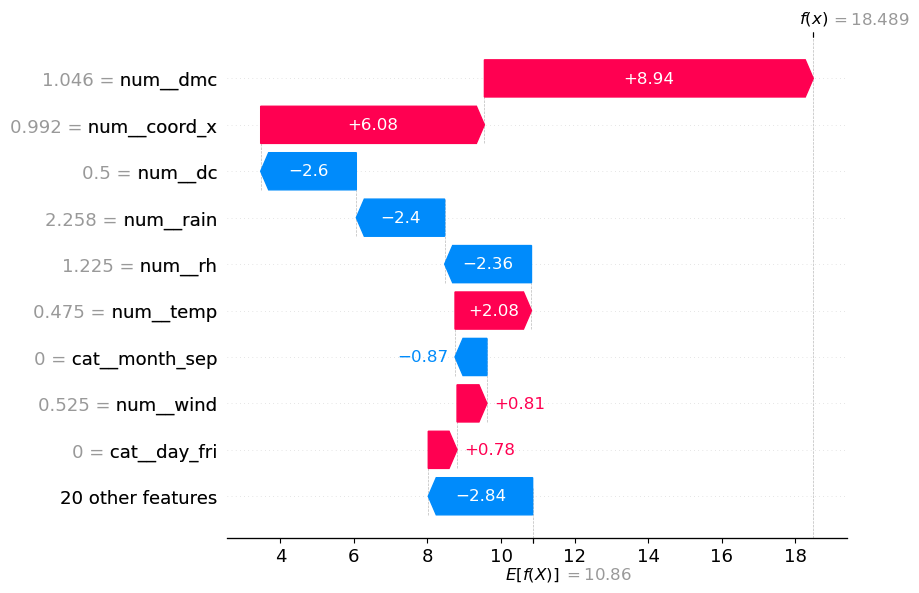

In [139]:
shap.plots.waterfall(shap_values[1])

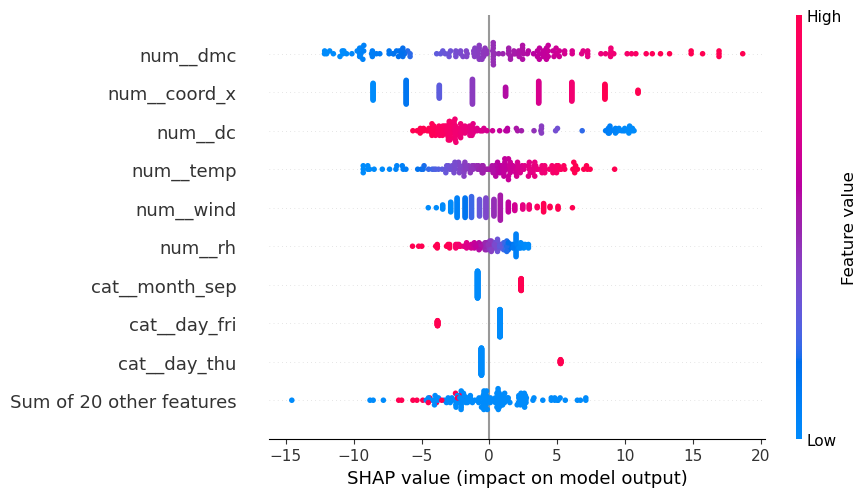

In [140]:
shap.plots.beeswarm(shap_values)

*(Answer here.)*
1. As per the waterfall plot, for the observation 1: The most important features contributing positively to the prediction are dmc and coord_x. 

dmc (8.94) and coord_x (6.08) are the strongest positive contributors to the model's prediction for this observation. This means that an increase in these features is associated with a higher predicted value for the output variable. 

temp (2.08) also has a positive contribution, indicating that higher temperature values lead to an increase in the model's prediction.

dc (-2.60), rain (-2.40), and rh (-2.36) are the most significant negative contributors. Their presence reduces the model's predicted output. This indicates that higher values of these features are associated with lower predictions.

20 other features collectively contributing -2.84 suggest that when these features are considered together, they have a negative impact on the prediction. It may be worth investigating which specific features contribute to this total and their individual importance.

2. As per the beeswarm plot, across the complete training set:

Most Important Features are: Dmc has the highest SHAP value, indicating it has a significant impact on the model’s predictions. Coord_x and dc also have strong impact on the predicted area.

Least Important Features are: Day_thu and day_fri have relatively low impact on the predictions, indicating that the day of the week is not a significant predictor for the model.

3. If I were to remove features from the model, I would consider removing: Day_Thu and day_fri. Given its low importance based on the SHAP values, removing this feature is unlikely to negatively impact the model's performance. It may simplify the model without sacrificing accuracy.

To test whether these features are enhancing model performance, I would follow these steps:
Create a Baseline Model: Train the original model with all features and evaluate it using metrics like Mean Squared Error (MSE) or R².
Remove Features: Build a new model excluding the identified less important features (e.g., day_thu and day_fri).
Evaluate Performance: Assess the reduced model's performance using the same metrics for direct comparison.
Use Cross-Validation: Implement cross-validation for a robust evaluation, reducing bias from a specific train-test split.
Compare Results: Analyze both models' results. If the reduced model performs comparably or better, the removed features likely didn’t enhance performance.
Feature Importance Reevaluation: Reassess the importance of remaining features using SHAP values to understand their contributions better.


## Criteria

The [rubric](./assignment_3_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.